# 3b Lasso and Ridge Linear Regression with Cross-validation

#### It has four main sections

## A. Imports, data shaping, and preprocessing

## B. Lasso CV regression on all features

## C. Lasso and Ridge regression on all features except `rating count`

## D. Lasso and Ridge regression on all features except `rating count` but with also `budget` added as a feature

# A. Imports and data shaping

In [836]:
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict
#from IPython.core.display import display, HTML
import pickle
import copy
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.model_selection import train_test_split
#display(HTML(my_html))     # make sure Jupyter knows to display it as HTML

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import  StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

In [837]:
pd.options.display.float_format = "{:,.5f}".format

In [838]:
#director = 'godard'
#director = 'hitchcock'
#director = 'bergman'
#director = 'fassbinder'
#director = 'herzog'
director = 'scorsese'
#director='allen'

In [839]:

dir_str = director + '/'

films_filename = 'films_to_analyze_' + director +'.pickle'
with open(dir_str + films_filename, 'rb') as read_file:
    films_to_analyze = pickle.load(read_file)

In [840]:
films_to_analyze.head()

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,A. Scott Berg,Rosamond Bernier,John Burgee,Dina Chandel,Eleanor Clark,Bette Davis,Geraldine Fitzgerald,Greer Garson,Joan Givner,Fred Sica
5,Pretend It's a City,"2,021.00000",8 January 2021 (USA),203.00000,203.00000,NaN,NaN,NaN,NaN,8.30000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
7,The Irishman,"2,019.00000",27 November 2019 (USA),209.00000,209.00000,"159,000,000.00000","910,234.00000","968,853.00000","910,234.00000",7.90000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
8,Rolling Thunder Revue: A Bob Dylan Story by Ma...,"2,019.00000",12 June 2019 (USA),142.00000,142.00000,NaN,NaN,NaN,NaN,7.60000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
9,Silence,"2,016.00000",13 January 2017 (USA),161.00000,161.00000,"46,000,000.00000","23,726,626.00000","23,834,809.00000","23,726,626.00000",7.20000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
10,Vinyl,"2,016.00000",14 February 2016 (USA),60.00000,60.00000,"100,000,000.00000",NaN,NaN,NaN,7.80000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [841]:
prevalent_actors_filename  = 'prevalent_actors_' + director +'.pickle'
with open(dir_str + prevalent_actors_filename, 'rb') as read_file:
    prevalent_actor_columns = pickle.load(read_file)

In [842]:
prevalent_actor_columns

Index(['Robert De Niro', 'Martin Scorsese', 'Leonardo DiCaprio',
       'Harvey Keitel', 'Joe Pesci', 'Catherine Scorsese', 'Eric Clapton',
       'Harry Northup', 'Victor Argo', 'Michael Stuhlbarg', 'Charles Scorsese',
       'Barry Primus', 'Ringo Starr', 'Frank Vincent', 'Bob Dylan',
       'Paul Herman', 'Murray Moston', 'Stephen Graham', 'Verna Bloom',
       'Alec Baldwin', 'Ray Romano', 'Diahnne Abbott', 'Barbara Hershey',
       'Patricia Clarkson'],
      dtype='object')

In [843]:
pickled_dict_of_actors_filename = 'dict_of_actors_' + director +'.pickle'
with open(dir_str + pickled_dict_of_actors_filename, 'rb') as read_file:
    dict_of_all_actors  = pickle.load(read_file) 

In [844]:
analysis_columns = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', *prevalent_actor_columns]

In [845]:
analysis_columns

['title',
 'year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'rating_count',
 'Robert De Niro',
 'Martin Scorsese',
 'Leonardo DiCaprio',
 'Harvey Keitel',
 'Joe Pesci',
 'Catherine Scorsese',
 'Eric Clapton',
 'Harry Northup',
 'Victor Argo',
 'Michael Stuhlbarg',
 'Charles Scorsese',
 'Barry Primus',
 'Ringo Starr',
 'Frank Vincent',
 'Bob Dylan',
 'Paul Herman',
 'Murray Moston',
 'Stephen Graham',
 'Verna Bloom',
 'Alec Baldwin',
 'Ray Romano',
 'Diahnne Abbott',
 'Barbara Hershey',
 'Patricia Clarkson']

## Dataset partitioned for analysis
except one-hot-encoding `cinematographer`

In [846]:
films_to_analyze.head()

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,A. Scott Berg,Rosamond Bernier,John Burgee,Dina Chandel,Eleanor Clark,Bette Davis,Geraldine Fitzgerald,Greer Garson,Joan Givner,Fred Sica
5,Pretend It's a City,"2,021.00000",8 January 2021 (USA),203.00000,203.00000,NaN,NaN,NaN,NaN,8.30000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
7,The Irishman,"2,019.00000",27 November 2019 (USA),209.00000,209.00000,"159,000,000.00000","910,234.00000","968,853.00000","910,234.00000",7.90000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
8,Rolling Thunder Revue: A Bob Dylan Story by Ma...,"2,019.00000",12 June 2019 (USA),142.00000,142.00000,NaN,NaN,NaN,NaN,7.60000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
9,Silence,"2,016.00000",13 January 2017 (USA),161.00000,161.00000,"46,000,000.00000","23,726,626.00000","23,834,809.00000","23,726,626.00000",7.20000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
10,Vinyl,"2,016.00000",14 February 2016 (USA),60.00000,60.00000,"100,000,000.00000",NaN,NaN,NaN,7.80000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [847]:
films_and_features_to_analyze_df = films_to_analyze[analysis_columns]

In [848]:
films_and_features_to_analyze_df.head() 

,title,year,duration,cinematographer,documentary,tv_series,rating,rating_count,Robert De Niro,Martin Scorsese,...,Bob Dylan,Paul Herman,Murray Moston,Stephen Graham,Verna Bloom,Alec Baldwin,Ray Romano,Diahnne Abbott,Barbara Hershey,Patricia Clarkson
5,Pretend It's a City,"2,021.00000",203.00000,Ellen Kuras,1.00000,1.00000,8.30000,"1,913.00000",0.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
7,The Irishman,"2,019.00000",209.00000,Rodrigo Prieto,0.00000,0.00000,7.90000,"322,963.00000",1.00000,0.00000,...,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
8,Rolling Thunder Revue: A Bob Dylan Story by Ma...,"2,019.00000",142.00000,Howard Alk,1.00000,0.00000,7.60000,"5,300.00000",0.00000,0.00000,...,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
9,Silence,"2,016.00000",161.00000,Rodrigo Prieto,0.00000,0.00000,7.20000,"100,119.00000",0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
10,Vinyl,"2,016.00000",60.00000,Reed Morano,0.00000,1.00000,7.80000,"21,636.00000",0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000


In [849]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

1

In [850]:
value_counts = films_and_features_to_analyze_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Regression analysis on `rating`,  `duration`, and `year` etc

#### `rating` as target

### Selecting columns for Train Test Split

In [851]:
films_and_features_to_analyze_df.columns # review columns we start with

Index(['title', 'year', 'duration', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'rating_count', 'Robert De Niro',
       'Martin Scorsese', 'Leonardo DiCaprio', 'Harvey Keitel', 'Joe Pesci',
       'Catherine Scorsese', 'Eric Clapton', 'Harry Northup', 'Victor Argo',
       'Michael Stuhlbarg', 'Charles Scorsese', 'Barry Primus', 'Ringo Starr',
       'Frank Vincent', 'Bob Dylan', 'Paul Herman', 'Murray Moston',
       'Stephen Graham', 'Verna Bloom', 'Alec Baldwin', 'Ray Romano',
       'Diahnne Abbott', 'Barbara Hershey', 'Patricia Clarkson'],
      dtype='object')

In [852]:
selected_cols = [*films_and_features_to_analyze_df.columns[1:6], *films_and_features_to_analyze_df.columns[7:]]

In [853]:
selected_cols

['year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating_count',
 'Robert De Niro',
 'Martin Scorsese',
 'Leonardo DiCaprio',
 'Harvey Keitel',
 'Joe Pesci',
 'Catherine Scorsese',
 'Eric Clapton',
 'Harry Northup',
 'Victor Argo',
 'Michael Stuhlbarg',
 'Charles Scorsese',
 'Barry Primus',
 'Ringo Starr',
 'Frank Vincent',
 'Bob Dylan',
 'Paul Herman',
 'Murray Moston',
 'Stephen Graham',
 'Verna Bloom',
 'Alec Baldwin',
 'Ray Romano',
 'Diahnne Abbott',
 'Barbara Hershey',
 'Patricia Clarkson']

In [854]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [855]:
y.isnull().values.any()

False

### Train-val vs. test split

In [856]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [857]:
X_test

,year,duration,cinematographer,documentary,tv_series,rating_count,Robert De Niro,Martin Scorsese,Leonardo DiCaprio,Harvey Keitel,...,Bob Dylan,Paul Herman,Murray Moston,Stephen Graham,Verna Bloom,Alec Baldwin,Ray Romano,Diahnne Abbott,Barbara Hershey,Patricia Clarkson
57,"1,974.00000",112.00000,Kent L. Wakeford,0.00000,0.00000,"21,361.00000",0.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
38,"1,995.00000",178.00000,Robert Richardson,0.00000,0.00000,"465,192.00000",1.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
39,"1,993.00000",139.00000,Michael Ballhaus,0.00000,0.00000,"52,892.00000",0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
62,"1,970.00000",107.00000,OTHER,0.00000,0.00000,"4,431.00000",0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
53,"1,978.00000",55.00000,Michael Chapman,1.00000,0.00000,"1,190.00000",0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
59,"1,973.00000",112.00000,Kent L. Wakeford,0.00000,0.00000,"99,994.00000",1.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
10,"2,016.00000",60.00000,OTHER,0.00000,1.00000,"21,636.00000",0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
21,"2,010.00000",138.00000,Robert Richardson,0.00000,0.00000,"1,126,811.00000",0.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
15,"2,011.00000",126.00000,Robert Richardson,0.00000,0.00000,"304,665.00000",0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
9,"2,016.00000",161.00000,Rodrigo Prieto,0.00000,0.00000,"100,119.00000",0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


## Preprocessing

### Categorical Variable Preprocessing

#### One-hot-encoding

In [858]:
cat_ohe_vars = ['cinematographer']
X_train_val_cat_ohe = X_train_val[cat_ohe_vars]
#X_train_cat_ohe 

In [859]:
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_val_cat_ohe)
cat_ohe = ohe.transform(X_train_val_cat_ohe)

In [860]:
columns=ohe.get_feature_names(cat_ohe_vars)
columns

array(['cinematographer_Ellen Kuras', 'cinematographer_Fred Schuler',
       'cinematographer_Michael Ballhaus',
       'cinematographer_Michael Chapman', 'cinematographer_OTHER',
       'cinematographer_Robert Richardson',
       'cinematographer_Rodrigo Prieto'], dtype=object)

In [861]:
X_train_val_cat_ohe_df = pd.DataFrame(cat_ohe, columns=columns, index=X_train_val_cat_ohe.index)
X_train_val_cat_ohe_df.head()

,cinematographer_Ellen Kuras,cinematographer_Fred Schuler,cinematographer_Michael Ballhaus,cinematographer_Michael Chapman,cinematographer_OTHER,cinematographer_Robert Richardson,cinematographer_Rodrigo Prieto
13,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
36,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
50,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
30,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
27,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000


Repeating transformations on testing set

In [862]:
X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cat_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cat_ohe_test, columns=cat_ohe_columns)


### Continuous Variable Preprocessing

In [863]:
cont_column_names = ['year', 'duration', 'rating_count']
X_train_val_cont = X_train_val[cont_column_names ]

X_test_cont      = X_test[     cont_column_names ]


X_train_val_cont.head()


,year,duration,rating_count
13,"2,014.00000",38.00000,110.00000
36,"1,995.00000",89.00000,"2,146.00000"
50,"1,985.00000",97.00000,"59,306.00000"
30,"2,002.00000",167.00000,"405,055.00000"
27,"2,004.00000",55.00000,83.00000


In [864]:
#X_train_val_cont_poly.head()

In [865]:
X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
X_train_val_cont['log_rating_count'] = np.log(X_train_val_cont.rating_count)


X_test_cont['log_year']         = np.log(X_test_cont.year)
X_test_cont['log_rating_count'] = np.log(X_test_cont.rating_count)

<ipython-input-865-d30627963e3a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
<ipython-input-865-d30627963e3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_rating_count'] = np.log(X_train_val_cont.rating_count)
<ipython-input-865-d30627963e3a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [866]:
X_test_cont.shape[0]

10

#### Concatenate columns

In [867]:
cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_val_cat_df = X_train_val[cat_columns]
#X_train_val_cat_df

X_test_cat_df = X_test[cat_columns]
#X_train_val_cat_df

In [868]:
X_test_cat_df.isnull().values.any()

False

In [869]:
X_train_val_combo= pd.concat([X_train_val_cont, X_train_val_cat_ohe_df, X_train_val_cat_df, ], axis='columns')
X_test_combo = pd.concat([X_test_cont.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True), ], axis='columns')

In [870]:
X_test_cat_df.shape

(10, 26)

In [871]:
X_train_val_combo.isnull().values.any()

False

In [872]:
X_test_combo.isnull().values.any()

False

In [873]:
X_test_combo

,year,duration,rating_count,log_year,log_rating_count,cinematographer_Ellen Kuras,cinematographer_Fred Schuler,cinematographer_Michael Ballhaus,cinematographer_Michael Chapman,cinematographer_OTHER,...,Bob Dylan,Paul Herman,Murray Moston,Stephen Graham,Verna Bloom,Alec Baldwin,Ray Romano,Diahnne Abbott,Barbara Hershey,Patricia Clarkson
0,"1,974.00000",112.00000,"21,361.00000",7.58782,9.96932,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,"1,995.00000",178.00000,"465,192.00000",7.59840,13.05021,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,"1,993.00000",139.00000,"52,892.00000",7.59740,10.87601,0.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,"1,970.00000",107.00000,"4,431.00000",7.58579,8.39638,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,"1,978.00000",55.00000,"1,190.00000",7.58984,7.08171,0.00000,0.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,"1,973.00000",112.00000,"99,994.00000",7.58731,11.51287,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
6,"2,016.00000",60.00000,"21,636.00000",7.60887,9.98211,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
7,"2,010.00000",138.00000,"1,126,811.00000",7.60589,13.93490,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
8,"2,011.00000",126.00000,"304,665.00000",7.60639,12.62697,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
9,"2,016.00000",161.00000,"100,119.00000",7.60887,11.51411,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [874]:
selected_columns = X_train_val_combo.columns
X_train_val_combo.columns

Index(['year', 'duration', 'rating_count', 'log_year', 'log_rating_count',
       'cinematographer_Ellen Kuras', 'cinematographer_Fred Schuler',
       'cinematographer_Michael Ballhaus', 'cinematographer_Michael Chapman',
       'cinematographer_OTHER', 'cinematographer_Robert Richardson',
       'cinematographer_Rodrigo Prieto', 'documentary', 'tv_series',
       'Robert De Niro', 'Martin Scorsese', 'Leonardo DiCaprio',
       'Harvey Keitel', 'Joe Pesci', 'Catherine Scorsese', 'Eric Clapton',
       'Harry Northup', 'Victor Argo', 'Michael Stuhlbarg', 'Charles Scorsese',
       'Barry Primus', 'Ringo Starr', 'Frank Vincent', 'Bob Dylan',
       'Paul Herman', 'Murray Moston', 'Stephen Graham', 'Verna Bloom',
       'Alec Baldwin', 'Ray Romano', 'Diahnne Abbott', 'Barbara Hershey',
       'Patricia Clarkson'],
      dtype='object')

### Train vs. val split

In [875]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val_combo, y_train_val, test_size=.25, random_state=43)

In [876]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

#mae(y_test, test_set_pred)

## B. Lasso CV regression on all features


### Lasso CV

In [877]:
X_train_val_combo.values

array([[2.014000e+03, 3.800000e+01, 1.100000e+02, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.995000e+03, 8.900000e+01, 2.146000e+03, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.985000e+03, 9.700000e+01, 5.930600e+04, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [2.006000e+03, 1.510000e+02, 1.187014e+06, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.990000e+03, 1.460000e+02, 1.018169e+06, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.976000e+03, 1.140000e+02, 7.228890e+05, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00]])

In [878]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train_val_combo.values)

StandardScaler()

In [879]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val_combo.values)
X_te = std.transform(X_test_combo.values)

In [880]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train_val)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [881]:
# This is the best alpha value it found 
lasso_model.alpha_

0.16070528182616392

In [882]:
len(lasso_model.coef_)

38

In [883]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_train.columns, lasso_model.coef_))
coefficients

[('year', 0.0),
 ('duration', 0.0),
 ('rating_count', 0.09206978113345518),
 ('log_year', 0.0),
 ('log_rating_count', 0.13360547352857924),
 ('cinematographer_Ellen Kuras', 0.0),
 ('cinematographer_Fred Schuler', -0.0),
 ('cinematographer_Michael Ballhaus', 0.0),
 ('cinematographer_Michael Chapman', 0.18634261740656202),
 ('cinematographer_OTHER', -0.0),
 ('cinematographer_Robert Richardson', -0.0),
 ('cinematographer_Rodrigo Prieto', 0.0),
 ('documentary', 0.0),
 ('tv_series', 0.0),
 ('Robert De Niro', 0.0),
 ('Martin Scorsese', 0.0),
 ('Leonardo DiCaprio', 0.0),
 ('Harvey Keitel', -0.0),
 ('Joe Pesci', 0.0007364133976122368),
 ('Catherine Scorsese', 0.0),
 ('Eric Clapton', 0.0),
 ('Harry Northup', -0.08822749191299926),
 ('Victor Argo', -0.0),
 ('Michael Stuhlbarg', 0.0),
 ('Charles Scorsese', 0.0),
 ('Barry Primus', -0.0),
 ('Ringo Starr', 0.026807379938573763),
 ('Frank Vincent', 0.0),
 ('Bob Dylan', 0.0),
 ('Paul Herman', -0.0),
 ('Murray Moston', -0.0),
 ('Stephen Graham', 0.0),


In [884]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [885]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.3049567045278033

In [886]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 

0.3368852284428998

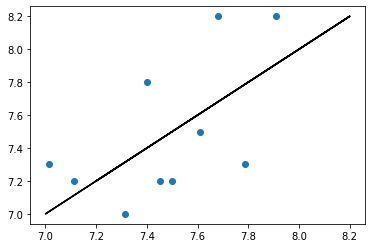

In [887]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

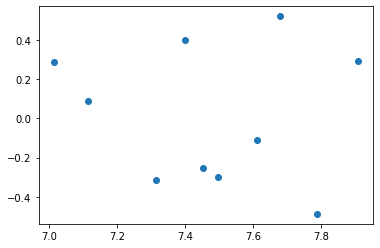

In [888]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)

In [889]:
coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])

coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df.head(20)

,Feature,Coefficient
8,cinematographer_Michael Chapman,0.18634
4,log_rating_count,0.13361
2,rating_count,0.09207
21,Harry Northup,-0.08823
26,Ringo Starr,0.02681
18,Joe Pesci,0.00074
0,year,0.00000
28,Bob Dylan,0.00000
23,Michael Stuhlbarg,0.00000
24,Charles Scorsese,0.00000


In [890]:
Lasso_CV_model_w_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Lasso_CV_model_w_rc 

{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.3049567045278033,
 'coefficients':                               Feature  Coefficient
 8     cinematographer_Michael Chapman      0.18634
 4                    log_rating_count      0.13361
 2                        rating_count      0.09207
 21                      Harry Northup     -0.08823
 26                        Ringo Starr      0.02681
 18                          Joe Pesci      0.00074
 0                                year      0.00000
 28                          Bob Dylan      0.00000
 23                  Michael Stuhlbarg      0.00000
 24                   Charles Scorsese      0.00000
 25                       Barry Primus     -0.00000
 27                      Frank Vincent      0.00000
 31                     Stephen Graham      0.00000
 29                        Paul Herman     -0.00000
 30                      Mur

In [891]:
LCVM_w_rc_filename = 'Lasso_CV_model_w_rc_' + director +'.pickle'
with open(dir_str + LCVM_w_rc_filename, 'wb') as to_write:
    pickle.dump(Lasso_CV_model_w_rc, to_write)

# C. Lasso and Ridge regression on all features except `rating count`



### Rerun the model without using rating count

In [892]:
X_tr = pd.DataFrame(X_tr, columns=X_train.columns )
X_tr.head()

,year,duration,rating_count,log_year,log_rating_count,cinematographer_Ellen Kuras,cinematographer_Fred Schuler,cinematographer_Michael Ballhaus,cinematographer_Michael Chapman,cinematographer_OTHER,...,Bob Dylan,Paul Herman,Murray Moston,Stephen Graham,Verna Bloom,Alec Baldwin,Ray Romano,Diahnne Abbott,Barbara Hershey,Patricia Clarkson
0,1.21174,-1.65265,-0.53753,1.20931,-1.88617,-0.30151,4.12311,-0.44721,-0.40161,-0.84515,...,-0.30151,-0.30151,-0.16903,-0.30151,-0.30151,-0.30151,-0.24254,3.31662,-0.30151,-0.24254
1,-0.03650,-0.72869,-0.53128,-0.03267,-0.77308,-0.30151,-0.24254,-0.44721,2.48998,-0.84515,...,-0.30151,-0.30151,-0.16903,-0.30151,-0.30151,-0.30151,-0.24254,-0.30151,-0.30151,-0.24254
2,-0.69347,-0.58376,-0.35598,-0.69110,0.47048,-0.30151,-0.24254,2.23607,-0.40161,-0.84515,...,-0.30151,-0.30151,-0.16903,-0.30151,3.31662,-0.30151,-0.24254,-0.30151,-0.30151,-0.24254
3,0.42338,0.68441,0.70439,0.42627,1.19033,-0.30151,-0.24254,2.23607,-0.40161,-0.84515,...,-0.30151,-0.30151,-0.16903,3.31662,-0.30151,-0.30151,-0.24254,-0.30151,-0.30151,-0.24254
4,0.55477,-1.34466,-0.53761,0.55710,-1.99169,-0.30151,-0.24254,-0.44721,-0.40161,1.18322,...,-0.30151,-0.30151,-0.16903,-0.30151,-0.30151,-0.30151,-0.24254,-0.30151,-0.30151,-0.24254


In [893]:
X_te = pd.DataFrame(X_te, columns=X_train.columns )

In [894]:
X_tr_no_rc  = X_tr.drop(columns = ['rating_count', 'log_rating_count'])

In [895]:
X_te_no_rc = X_te.drop(columns = ['rating_count', 'log_rating_count'])

In [896]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr_no_rc, y_train_val)

# This is the best alpha value it found 
lasso_model.alpha_

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018432891412731855, tolerance: 0.0017886785714285708
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001955083763718779, tolerance: 0.0017886785714285708
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020471073387704486, tolerance: 0.0017886785714285708
  model = cd_fast.enet_coordinate_descent(


0.1762914118095948

In [897]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_tr_no_rc.columns, lasso_model.coef_))
coefficients_df = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient']).sort_values(by='Coefficient', ascending=False)

In [898]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te_no_rc)

In [899]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.35055032272261766

In [900]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 


-0.06870923113594674

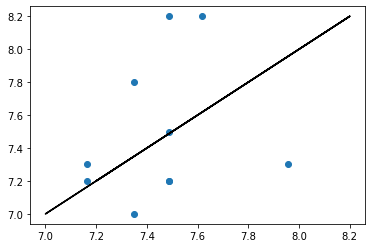

In [901]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')
#plt.plot( x_te_no_rc, y_test, c='k')

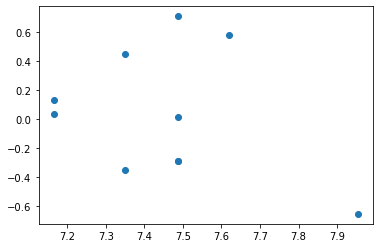

In [902]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)



In [903]:
coefficients_df.head()

,Feature,Coefficient
6,cinematographer_Michael Chapman,0.16152
16,Joe Pesci,0.04132
0,year,0.00000
27,Paul Herman,-0.00000
22,Charles Scorsese,0.00000


In [904]:
Lasso_CV_model_no_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Lasso_CV_model_no_rc 


{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.35055032272261766,
 'coefficients':                               Feature  Coefficient
 6     cinematographer_Michael Chapman      0.16152
 16                          Joe Pesci      0.04132
 0                                year      0.00000
 27                        Paul Herman     -0.00000
 22                   Charles Scorsese      0.00000
 23                       Barry Primus     -0.00000
 24                        Ringo Starr      0.00000
 25                      Frank Vincent      0.00000
 26                          Bob Dylan      0.00000
 28                      Murray Moston     -0.00000
 20                        Victor Argo     -0.00000
 29                     Stephen Graham      0.00000
 30                        Verna Bloom     -0.00000
 31                       Alec Baldwin      0.00000
 32                        

In [905]:
LCVM_no_rc_filename = 'Lasso_CV_model_no_rc_' + director +'.pickle'
with open(dir_str + LCVM_no_rc_filename, 'wb') as to_write:
    pickle.dump(Lasso_CV_model_no_rc, to_write)

In [906]:
from sklearn.linear_model import lars_path
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(np.array(X_tr_no_rc), y_train_val.values, method='lasso')

Computing regularization path using the LARS ...


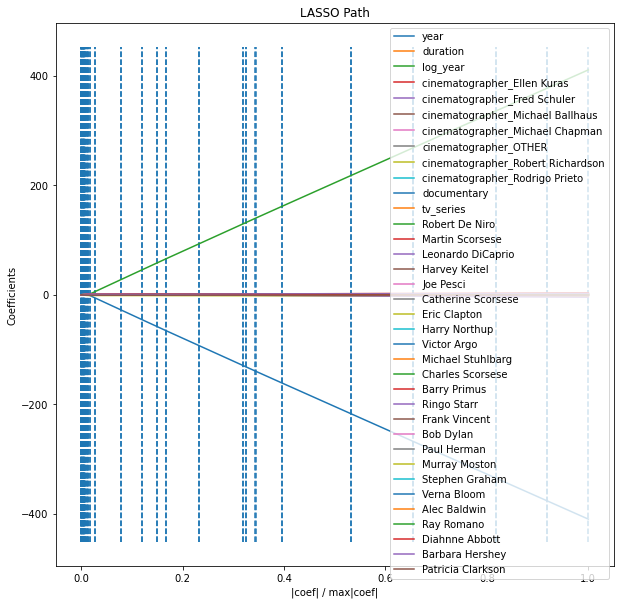

In [907]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_tr_no_rc.columns)
plt.show()

### Ridge regression

In [908]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr_no_rc, y_train_val)

# This is the best alpha value it found 
ridge_model.alpha_

100.0

In [909]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_tr_no_rc.columns, ridge_model.coef_))

coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])

coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df

,Feature,Coefficient
6,cinematographer_Michael Chapman,0.08736
7,cinematographer_OTHER,-0.06220
19,Harry Northup,-0.05431
24,Ringo Starr,0.04503
22,Charles Scorsese,0.03801
16,Joe Pesci,0.03593
25,Frank Vincent,0.03450
31,Alec Baldwin,0.03334
23,Barry Primus,-0.03232
8,cinematographer_Robert Richardson,-0.03066


In [910]:
# Make predictions on the test set using the new model
test_set_pred = ridge_model.predict(X_te_no_rc)

In [911]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.37086935811045657

In [912]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 


-0.052711465603213936

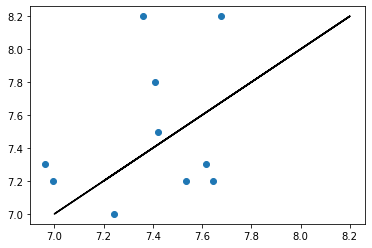

In [913]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

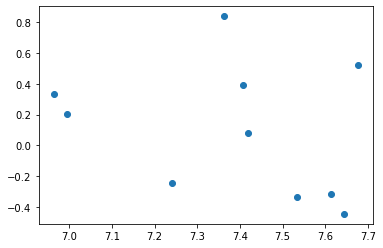

In [914]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)


In [915]:
coefficients_df.head()

,Feature,Coefficient
6,cinematographer_Michael Chapman,0.08736
7,cinematographer_OTHER,-0.06220
19,Harry Northup,-0.05431
24,Ringo Starr,0.04503
22,Charles Scorsese,0.03801


In [916]:
Ridge_CV_model_no_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Ridge_CV_model_no_rc 


{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.37086935811045657,
 'coefficients':                               Feature  Coefficient
 6     cinematographer_Michael Chapman      0.08736
 7               cinematographer_OTHER     -0.06220
 19                      Harry Northup     -0.05431
 24                        Ringo Starr      0.04503
 22                   Charles Scorsese      0.03801
 16                          Joe Pesci      0.03593
 25                      Frank Vincent      0.03450
 31                       Alec Baldwin      0.03334
 23                       Barry Primus     -0.03232
 8   cinematographer_Robert Richardson     -0.03066
 29                     Stephen Graham      0.02957
 35                  Patricia Clarkson     -0.02916
 5    cinematographer_Michael Ballhaus      0.02791
 2                            log_year      0.02613
 0                         

In [917]:
RCVM_no_rc_filename = 'Ridge_CV_model_no_rc_' + director +'.pickle'
with open(dir_str + RCVM_no_rc_filename, 'wb') as to_write:
    pickle.dump(Ridge_CV_model_no_rc, to_write)

# D. Lasso and Ridge regression on all features except `rating count` but with also `budget` added as a feature

#### Re-analyzed including `budget` as a feature 
This entails a fewer rows of data, since many of the films don't have budget info available on IMDB

In [918]:
films_to_analyze_financial_df = films_to_analyze[(films_to_analyze['budget'] > 0) & (films_to_analyze['worldwide_gross'] > 0)]

In [919]:
analysis_columns = ['title', 'year', 'duration', 'budget', 'cinematographer', 'documentary', 'tv_series','rating', *prevalent_actor_columns]

In [920]:
analysis_columns = ['title', 'year', 'duration', 'budget', 'cinematographer', 'documentary', 'tv_series','rating', *prevalent_actor_columns]

In [921]:
analysis_columns 

['title',
 'year',
 'duration',
 'budget',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'Robert De Niro',
 'Martin Scorsese',
 'Leonardo DiCaprio',
 'Harvey Keitel',
 'Joe Pesci',
 'Catherine Scorsese',
 'Eric Clapton',
 'Harry Northup',
 'Victor Argo',
 'Michael Stuhlbarg',
 'Charles Scorsese',
 'Barry Primus',
 'Ringo Starr',
 'Frank Vincent',
 'Bob Dylan',
 'Paul Herman',
 'Murray Moston',
 'Stephen Graham',
 'Verna Bloom',
 'Alec Baldwin',
 'Ray Romano',
 'Diahnne Abbott',
 'Barbara Hershey',
 'Patricia Clarkson']

In [922]:
films_and_features_to_analyze_df = films_to_analyze_financial_df[analysis_columns]

In [923]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

1

In [924]:
value_counts = films_and_features_to_analyze_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Regression analysis on `rating`,  `duration`, `year` and `budget` etc

In [925]:
films_and_features_to_analyze_df.columns

Index(['title', 'year', 'duration', 'budget', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'Robert De Niro', 'Martin Scorsese',
       'Leonardo DiCaprio', 'Harvey Keitel', 'Joe Pesci', 'Catherine Scorsese',
       'Eric Clapton', 'Harry Northup', 'Victor Argo', 'Michael Stuhlbarg',
       'Charles Scorsese', 'Barry Primus', 'Ringo Starr', 'Frank Vincent',
       'Bob Dylan', 'Paul Herman', 'Murray Moston', 'Stephen Graham',
       'Verna Bloom', 'Alec Baldwin', 'Ray Romano', 'Diahnne Abbott',
       'Barbara Hershey', 'Patricia Clarkson'],
      dtype='object')

In [926]:
selected_cols = [*films_and_features_to_analyze_df.columns[1:7], *films_and_features_to_analyze_df.columns[8:]]

In [927]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [928]:
X

,year,duration,budget,cinematographer,documentary,tv_series,Robert De Niro,Martin Scorsese,Leonardo DiCaprio,Harvey Keitel,...,Bob Dylan,Paul Herman,Murray Moston,Stephen Graham,Verna Bloom,Alec Baldwin,Ray Romano,Diahnne Abbott,Barbara Hershey,Patricia Clarkson
7,"2,019.00000",209.00000,"159,000,000.00000",Rodrigo Prieto,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,...,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
9,"2,016.00000",161.00000,"46,000,000.00000",Rodrigo Prieto,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
14,"2,013.00000",180.00000,"100,000,000.00000",Rodrigo Prieto,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
15,"2,011.00000",126.00000,"150,000,000.00000",Robert Richardson,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
21,"2,010.00000",138.00000,"80,000,000.00000",Robert Richardson,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
24,"2,006.00000",151.00000,"90,000,000.00000",Michael Ballhaus,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
26,"2,004.00000",170.00000,"110,000,000.00000",Robert Richardson,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
30,"2,002.00000",167.00000,"100,000,000.00000",Michael Ballhaus,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
33,"1,999.00000",121.00000,"55,000,000.00000",Robert Richardson,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
35,"1,997.00000",134.00000,"28,000,000.00000",OTHER,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [929]:
y.isnull().values.any()

False

In [930]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [931]:
# X_train_val

## Preprocessing


### Categorical Variable Preprocessing

#### One-hot-encoding

In [932]:
cat_ohe_vars = ['cinematographer']
X_train_val_cat_ohe = X_train_val[cat_ohe_vars]
#X_train_cat_ohe 

In [933]:
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_val_cat_ohe)
cat_ohe = ohe.transform(X_train_val_cat_ohe)

In [934]:
columns=ohe.get_feature_names(cat_ohe_vars)
columns

array(['cinematographer_Kent L. Wakeford',
       'cinematographer_Michael Ballhaus',
       'cinematographer_Michael Chapman', 'cinematographer_OTHER',
       'cinematographer_Robert Richardson',
       'cinematographer_Rodrigo Prieto'], dtype=object)

In [935]:
cat_ohe.shape[0]

20

In [936]:
X_train_val_cat_ohe.shape[0]

20

In [937]:
X_train_val_cat_ohe_df = pd.DataFrame(cat_ohe, columns=columns, index=X_train_val_cat_ohe.index)
X_train_val_cat_ohe_df.head()

,cinematographer_Kent L. Wakeford,cinematographer_Michael Ballhaus,cinematographer_Michael Chapman,cinematographer_OTHER,cinematographer_Robert Richardson,cinematographer_Rodrigo Prieto
43,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
9,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
59,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
24,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
14,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000


In [938]:
X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cat_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cat_ohe_test, columns=cat_ohe_columns)


### Continuous Variable Preprocessing

In [939]:
cont_column_names = ['year', 'duration', 'budget']
X_train_val_cont = X_train_val[cont_column_names ]

X_test_cont      = X_test[     cont_column_names ]


X_train_val_cont.head()

,year,duration,budget
43,"1,990.00000",146.00000,"25,000,000.00000"
9,"2,016.00000",161.00000,"46,000,000.00000"
59,"1,973.00000",112.00000,"500,000.00000"
24,"2,006.00000",151.00000,"90,000,000.00000"
14,"2,013.00000",180.00000,"100,000,000.00000"


In [940]:
X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
X_train_val_cont['log_budget']         = np.log(X_train_val_cont.budget)
X_train_val_cont['budget_sq'] = X_train_val_cont.budget**2
#X_train_val_cont['budget_per_year'] = X_train_val_cont.budget/X_train_val_cont.year


X_test_cont['log_year']         = np.log(X_test_cont.year)
X_test_cont['log_budget']         = np.log(X_test_cont.budget)
X_test_cont['budget_sq']  =  X_test_cont.budget**2
#X_test_cont['budget_per_year']  =   X_test_cont.budget/X_test_cont.year

<ipython-input-940-02b26dca41c8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
<ipython-input-940-02b26dca41c8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_budget']         = np.log(X_train_val_cont.budget)
<ipython-input-940-02b26dca41c8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [941]:
X_test_cont.shape[0]

6

#### Concatenate columns

In [942]:
cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_val_cat_df = X_train_val[cat_columns]
#X_train_val_cat_df

X_test_cat_df = X_test[cat_columns]
#X_train_val_cat_df

In [943]:
X_test_cat_df.isnull().values.any()

False

In [944]:
X_train_val_combo= pd.concat([X_train_val_cont, X_train_val_cat_ohe_df, X_train_val_cat_df, ], axis='columns')
X_test_combo = pd.concat([X_test_cont.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True), ], axis='columns')

In [945]:
X_test_cat_df.shape

(6, 26)

In [946]:
X_train_val_combo.isnull().values.any()

False

In [947]:
X_test_combo.isnull().values.any()

False

In [948]:
X_test_combo

,year,duration,budget,log_year,log_budget,budget_sq,cinematographer_Kent L. Wakeford,cinematographer_Michael Ballhaus,cinematographer_Michael Chapman,cinematographer_OTHER,...,Bob Dylan,Paul Herman,Murray Moston,Stephen Graham,Verna Bloom,Alec Baldwin,Ray Romano,Diahnne Abbott,Barbara Hershey,Patricia Clarkson
0,"1,999.00000",121.00000,"55,000,000.00000",7.60040,17.82284,"3,025,000,000,000,000.00000",0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,"1,986.00000",119.00000,"13,800,000.00000",7.59388,16.44018,"190,440,000,000,000.00000",0.00000,1.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,"2,019.00000",209.00000,"159,000,000.00000",7.61036,18.88441,"25,281,000,000,000,000.00000",0.00000,0.00000,0.00000,0.00000,...,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
3,"1,972.00000",88.00000,"600,000.00000",7.58680,13.30468,"360,000,000,000.00000",0.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
4,"1,993.00000",139.00000,"34,000,000.00000",7.59740,17.34187,"1,156,000,000,000,000.00000",0.00000,1.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,"1,997.00000",134.00000,"28,000,000.00000",7.59940,17.14772,"784,000,000,000,000.00000",0.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [949]:
selected_columns = X_train_val_combo.columns
X_train_val_combo.columns

Index(['year', 'duration', 'budget', 'log_year', 'log_budget', 'budget_sq',
       'cinematographer_Kent L. Wakeford', 'cinematographer_Michael Ballhaus',
       'cinematographer_Michael Chapman', 'cinematographer_OTHER',
       'cinematographer_Robert Richardson', 'cinematographer_Rodrigo Prieto',
       'documentary', 'tv_series', 'Robert De Niro', 'Martin Scorsese',
       'Leonardo DiCaprio', 'Harvey Keitel', 'Joe Pesci', 'Catherine Scorsese',
       'Eric Clapton', 'Harry Northup', 'Victor Argo', 'Michael Stuhlbarg',
       'Charles Scorsese', 'Barry Primus', 'Ringo Starr', 'Frank Vincent',
       'Bob Dylan', 'Paul Herman', 'Murray Moston', 'Stephen Graham',
       'Verna Bloom', 'Alec Baldwin', 'Ray Romano', 'Diahnne Abbott',
       'Barbara Hershey', 'Patricia Clarkson'],
      dtype='object')

### Train vs. val split



In [950]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val_combo, y_train_val, test_size=.25, random_state=43) #43

### Lasso CV

In [951]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train_val_combo.values)

StandardScaler()

In [952]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val_combo.values)
X_te = std.transform(X_test_combo.values)

In [953]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train_val)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [954]:
# This is the best alpha value it found 
lasso_model.alpha_

0.08804883581643465

In [955]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_train_val_combo.columns, lasso_model.coef_))
coefficients

[('year', 0.0),
 ('duration', 0.0),
 ('budget', 0.0),
 ('log_year', 0.0),
 ('log_budget', 0.0),
 ('budget_sq', 0.0),
 ('cinematographer_Kent L. Wakeford', -0.0),
 ('cinematographer_Michael Ballhaus', 0.02444754008564104),
 ('cinematographer_Michael Chapman', 0.0),
 ('cinematographer_OTHER', -0.2265271866387371),
 ('cinematographer_Robert Richardson', 0.0),
 ('cinematographer_Rodrigo Prieto', -0.0),
 ('documentary', 0.0),
 ('tv_series', 0.0),
 ('Robert De Niro', 0.0),
 ('Martin Scorsese', 0.0),
 ('Leonardo DiCaprio', 0.06764527453816274),
 ('Harvey Keitel', -0.0),
 ('Joe Pesci', 0.1619931039056106),
 ('Catherine Scorsese', 0.0),
 ('Eric Clapton', 0.0),
 ('Harry Northup', -0.06325732146174662),
 ('Victor Argo', 0.0),
 ('Michael Stuhlbarg', -0.0),
 ('Charles Scorsese', 0.017423342644693886),
 ('Barry Primus', -0.0),
 ('Ringo Starr', 0.0),
 ('Frank Vincent', 0.0),
 ('Bob Dylan', 0.0),
 ('Paul Herman', -0.05951629141972977),
 ('Murray Moston', -0.027540304970778605),
 ('Stephen Graham', -0.

In [956]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [957]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.5200057902497562

In [958]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 

-0.25524531772410697

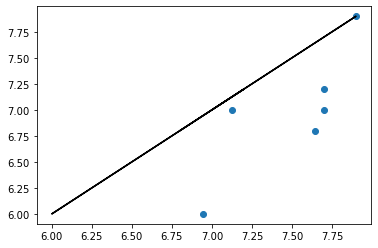

In [959]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

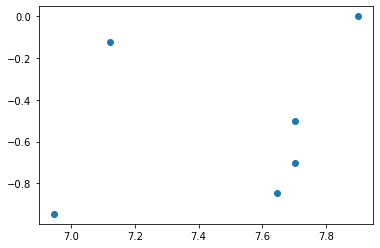

In [960]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)

In [961]:
pd.options.display.float_format = "{:,.5f}".format



In [962]:
coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])
coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df.head(10)
#print(coefficients_df.head(10))

,Feature,Coefficient
9,cinematographer_OTHER,-0.22653
18,Joe Pesci,0.16199
35,Diahnne Abbott,0.12046
16,Leonardo DiCaprio,0.06765
21,Harry Northup,-0.06326
29,Paul Herman,-0.05952
30,Murray Moston,-0.02754
7,cinematographer_Michael Ballhaus,0.02445
24,Charles Scorsese,0.01742
37,Patricia Clarkson,0.00307


In [963]:
Lasso_CV_model_w_budget = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Lasso_CV_model_w_budget 

{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.5200057902497562,
 'coefficients':                               Feature  Coefficient
 9               cinematographer_OTHER     -0.22653
 18                          Joe Pesci      0.16199
 35                     Diahnne Abbott      0.12046
 16                  Leonardo DiCaprio      0.06765
 21                      Harry Northup     -0.06326
 29                        Paul Herman     -0.05952
 30                      Murray Moston     -0.02754
 7    cinematographer_Michael Ballhaus      0.02445
 24                   Charles Scorsese      0.01742
 37                  Patricia Clarkson      0.00307
 31                     Stephen Graham     -0.00000
 32                        Verna Bloom     -0.00000
 28                          Bob Dylan      0.00000
 27                      Frank Vincent      0.00000
 26                        R

In [964]:
LCVM_w_budget_filename = 'Lasso_CV_model_w_budget_' + director +'.pickle'
with open(dir_str + LCVM_w_budget_filename, 'wb') as to_write:
    pickle.dump(Lasso_CV_model_w_budget, to_write)

### Ridge regression

In [965]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, y_train_val)

# This is the best alpha value it found 
ridge_model.alpha_

20.72921779595372

In [966]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_train.columns, ridge_model.coef_))


In [967]:
# Make predictions on the test set using the new model
test_set_pred = ridge_model.predict(X_te)

In [968]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.5690091259310054

In [969]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 

-0.14302057458246864

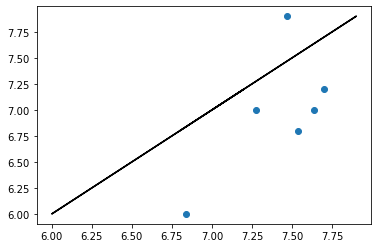

In [970]:

plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

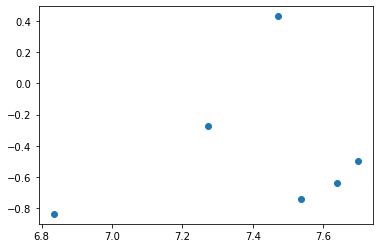

In [971]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)

In [972]:
coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])
coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df.head(40)

,Feature,Coefficient
9,cinematographer_OTHER,-0.10765
29,Paul Herman,-0.08331
35,Diahnne Abbott,0.08318
7,cinematographer_Michael Ballhaus,0.07796
18,Joe Pesci,0.06477
27,Frank Vincent,0.06477
16,Leonardo DiCaprio,0.06075
25,Barry Primus,-0.05833
14,Robert De Niro,0.05411
37,Patricia Clarkson,0.05006


In [973]:
Ridge_CV_model_w_budget = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Ridge_CV_model_w_budget 

{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.5690091259310054,
 'coefficients':                               Feature  Coefficient
 9               cinematographer_OTHER     -0.10765
 29                        Paul Herman     -0.08331
 35                     Diahnne Abbott      0.08318
 7    cinematographer_Michael Ballhaus      0.07796
 18                          Joe Pesci      0.06477
 27                      Frank Vincent      0.06477
 16                  Leonardo DiCaprio      0.06075
 25                       Barry Primus     -0.05833
 14                     Robert De Niro      0.05411
 37                  Patricia Clarkson      0.05006
 24                   Charles Scorsese      0.04993
 31                     Stephen Graham     -0.04880
 8     cinematographer_Michael Chapman      0.04328
 4                          log_budget      0.03530
 21                      Har

In [974]:
RCVM_w_budget_filename = 'Ridge_CV_model_w_budget_' + director +'.pickle'
with open(dir_str + RCVM_w_budget_filename, 'wb') as to_write:
    pickle.dump(Ridge_CV_model_w_budget, to_write)